In [1]:
import random
import copy


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import evaluate

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from datasets import Dataset, DatasetDict
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)



2026-02-20 16:25:59.531915: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)        
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Sets random seeds for reproducibility and selects GPU if available; otherwise uses CPU.

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


Loads the SignMNIST CSV files, extracts unique labels, defines class count, and creates mappings between numeric labels and letter labels.

In [4]:
train_df = pd.read_csv("sign_mnist_train.csv")
test_df  = pd.read_csv("sign_mnist_test.csv")

csv_unique_labels = sorted(train_df["label"].unique())
num_classes = len(csv_unique_labels)

print("Unique CSV labels:", csv_unique_labels)
print("Num classes:", num_classes)

alphabet = "ABCDEFGHIKLMNOPQRSTUVWXY"  # 24 letters (no J and Z)
assert len(alphabet) == num_classes, (
    f"alphabet has {len(alphabet)} names, but dataset has {num_classes} classes."
)

csv_label_to_id = {lab: i for i, lab in enumerate(csv_unique_labels)}
id2label = {i: alphabet[i] for i in range(num_classes)}
label2id = {alphabet[i]: i for i in range(num_classes)}


Unique CSV labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Num classes: 24


In [5]:
train_df.describe()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [6]:
train_df.head()



,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Prints dataset schema and checks for missing values in training and test data.

In [7]:
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

#Dataset info and missing values
print("\nTrain info:")
train_df.info()

print("\nMissing values (train):", train_df.isna().sum().sum())
print("Missing values (test) :", test_df.isna().sum().sum())



Train shape: (27455, 785)
Test shape : (7172, 785)

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB

Missing values (train): 0
Missing values (test) : 0


Visualizes the class distribution in the training set and prints per-class sample counts.

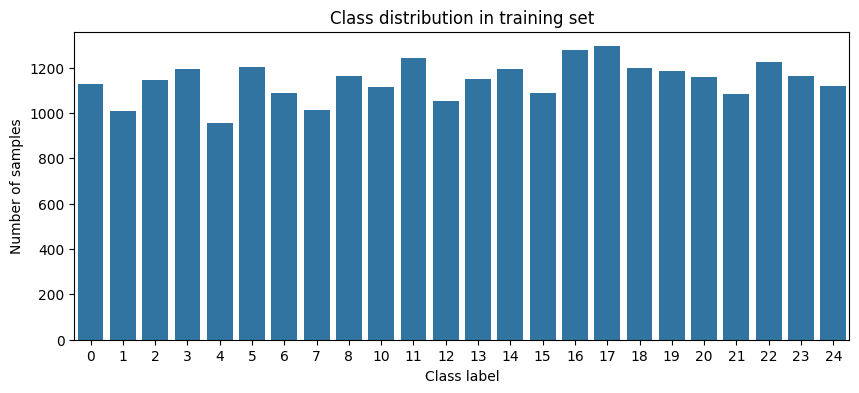


Class counts:
label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64


In [8]:
#Class distribution
plt.figure(figsize=(10,4))
sns.countplot(x="label", data=train_df)
plt.title("Class distribution in training set")
plt.xlabel("Class label")
plt.ylabel("Number of samples")
plt.savefig("class_dist")
plt.show()

print("\nClass counts:")
print(train_df["label"].value_counts().sort_index())


Reconstructs 28×28 images from flattened pixels and displays one sample per class with the corresponding letter label.


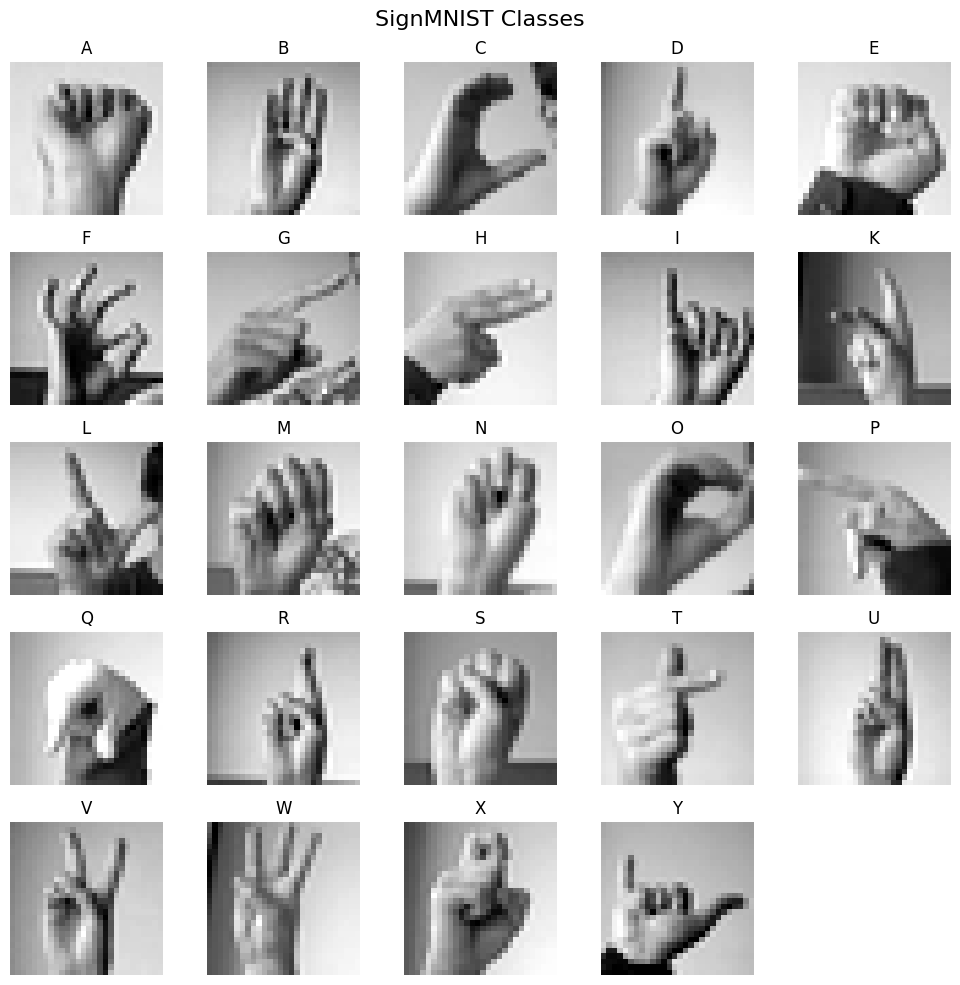

In [9]:

# Split features and labels from training CSV
x_train = train_df.drop(columns=["label"])
y_train = train_df["label"].values  # original CSV labels (e.g. 0,1,2,...,24 without 9)

labels = csv_unique_labels  # original label IDs from CSV

plt.figure(figsize=(10, 10))

for i, lab in enumerate(labels):
    # find first occurrence of this class
    idx = np.where(y_train == lab)[0][0]

    # get image and reshape
    img = x_train.iloc[idx].values.reshape(28, 28)

    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(id2label[i])  # mapped letter (A–Y without J)
    plt.axis("off")

plt.suptitle("SignMNIST Classes", fontsize=16)
plt.tight_layout()
plt.savefig("classes")
plt.show()


Creates a stratified train/validation split to preserve the label distribution across splits.

In [10]:
# Train/Val split
idx_all = np.arange(len(train_df))
y_all   = train_df["label"].values

train_idx, val_idx = train_test_split(
    idx_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

train_df_split = train_df.iloc[train_idx].reset_index(drop=True)
val_df_split   = train_df.iloc[val_idx].reset_index(drop=True)


Converts labels to contiguous class IDs, scales pixel values to [0,1], reshapes to image tensors, and expands grayscale to 3 channels. Wraps tensors into TensorDatasets and creates DataLoaders for training, validation, and testing with appropriate batch sizes.

In [11]:
def preprocess_signmnist_torch(df):
    y = torch.tensor([csv_label_to_id[int(v)] for v in df["label"].values], dtype=torch.long)

    x = df.drop(columns=["label"]).values.astype(np.float32) / 255.0
    x = torch.from_numpy(x).reshape(-1, 1, 28, 28)
    x = x.repeat(1, 3, 1, 1)

    return x, y


X_train, y_train = preprocess_signmnist_torch(train_df_split)
X_val,   y_val   = preprocess_signmnist_torch(val_df_split)
X_test,  y_test  = preprocess_signmnist_torch(test_df)

g = torch.Generator().manual_seed(42)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True, generator=g, num_workers=0)
val_loader   = DataLoader(TensorDataset(X_val, y_val),     batch_size=128, shuffle=False, num_workers=0)
test_loader  = DataLoader(TensorDataset(X_test, y_test),   batch_size=128, shuffle=False, num_workers=0)



Applies random spatial shifts, Gaussian noise, and occasional horizontal flips to training batches to improve generalization.

In [12]:
def augment(x):
    #Random horizontal shift + vertical shift
    if torch.rand(1) < 0.9:
        shift = 6  # pixels
        dx = int(torch.randint(-shift, shift + 1, (1,)).item())
        dy = int(torch.randint(-shift, shift + 1, (1,)).item())
        x = torch.roll(x, shifts=(dy, dx), dims=(2, 3))  # dims: H,W

    #Small gaussian noise
    if torch.rand(1) < 0.8:
        x = x + 0.03 * torch.randn_like(x)

    #optional flip (use smaller probability)
    if torch.rand(1) < 0.2:
        x = torch.flip(x, dims=[3])

    return x

Implement augment function and plot some examples

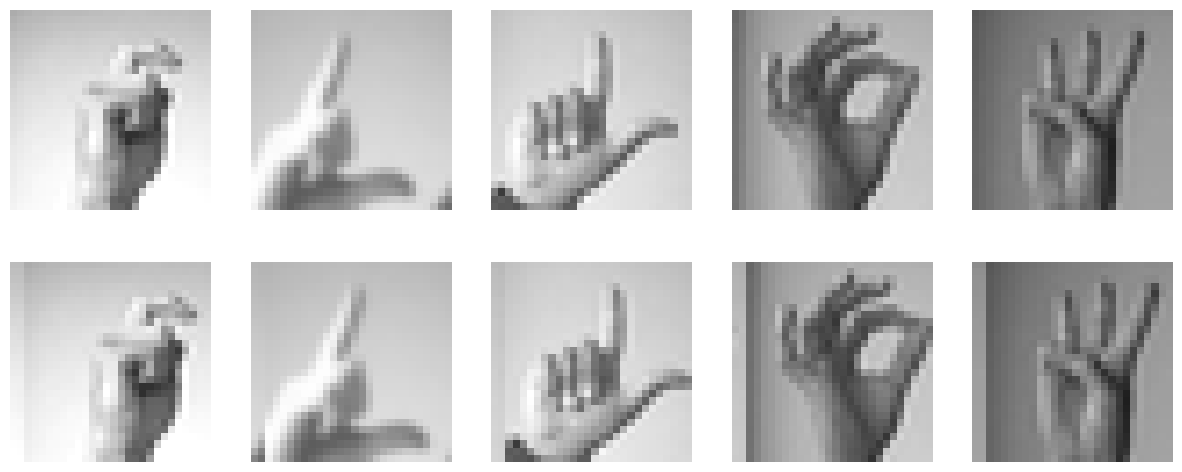

In [13]:
#Get one batch of the training data and augment them
images, labels = next(iter(train_loader))
aug_images = augment(images.clone().to(device)).cpu()

fig, axes = plt.subplots(2, 5, figsize=(15, 6)) 
for i in range(5):
    axes[0, i].imshow(images[i].permute(1, 2, 0))       # Original
    axes[1, i].imshow(aug_images[i].permute(1, 2, 0).detach().clamp(0,1)) # Augmentiert
    axes[0, i].axis('off'); axes[1, i].axis('off')


plt.savefig('aug.pdf', bbox_inches='tight')
plt.show()


### CONVOLUTIONAL NEURAL NETWORK

Defines a configurable CNN consisting of repeated Conv–ReLU–MaxPool blocks followed by a fully connected classifier.


In [14]:

class SimpleCNN(nn.Module):
    def __init__(self, num_conv_layers=2, in_channels=3, num_classes=25, input_size=224):
        super().__init__()
        layers = []
        out_channels = 16

        for _ in range(num_conv_layers):
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
            in_channels = out_channels
            out_channels *= 2

        self.conv_net = nn.Sequential(*layers)

        final_feature_map_size = input_size // (2 ** num_conv_layers)
        final_feature_map_size = max(final_feature_map_size, 1)

        self.fc = nn.Linear(in_channels * (final_feature_map_size ** 2), num_classes)

    def forward(self, x):
        x = self.conv_net(x)
        x = x.flatten(1)
        return self.fc(x)



Trains the CNN with cross-entropy loss, Adam optimization, learning-rate reduction on plateau, and early stopping based on validation loss.

In [15]:
def train_cnn(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=1e-3,
    patience=5,
    min_delta=1e-3,
    weight_decay=1e-4
):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        #train
        model.train()
        loss_sum, correct, total = 0.0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            # augment only training batches
            xb = augment(xb)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * xb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_loss = loss_sum / total
        train_acc = 100.0 * correct / total

        #validate
        model.eval()
        vloss_sum, vcorrect, vtotal = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                vloss_sum += loss.item() * xb.size(0)
                vcorrect += (logits.argmax(1) == yb).sum().item()
                vtotal += yb.size(0)

        val_loss = vloss_sum / vtotal
        val_acc = 100.0 * vcorrect / vtotal

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"[CNN] Epoch {epoch+1:02d}/{num_epochs} | "
              f"Train Loss {train_loss:.4f} Acc {train_acc:.2f}% | "
              f"Val Loss {val_loss:.4f} Acc {val_acc:.2f}%")

        #early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("[CNN] Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history



Computes class predictions for a DataLoader and calculates loss/accuracy on a DataLoader without gradient updates.

In [16]:
def predict_cnn(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_labels.append(yb.cpu())
    return torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()

def eval_acc(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    loss_sum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            loss_sum += loss.item() * xb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.size(0)

    return loss_sum / total, 100.0 * correct / total

Trains the CNN and evaluates on the test set.

In [17]:
#Train CNN
cnn = SimpleCNN(num_conv_layers=2, num_classes=num_classes, input_size=28)
cnn, cnn_hist = train_cnn(cnn, train_loader, val_loader, num_epochs=20)

#Evaluate CNN
test_loss, test_acc = eval_acc(cnn, test_loader)
print(f"[CNN] TEST | Loss {test_loss:.4f} | Acc {test_acc:.2f}%")




[CNN] Epoch 01/20 | Train Loss 2.6294 Acc 22.31% | Val Loss 1.2529 Acc 67.60%
[CNN] Epoch 02/20 | Train Loss 1.7698 Acc 46.72% | Val Loss 0.7800 Acc 81.55%
[CNN] Epoch 03/20 | Train Loss 1.3935 Acc 57.84% | Val Loss 0.5148 Acc 88.85%
[CNN] Epoch 04/20 | Train Loss 1.1887 Acc 63.78% | Val Loss 0.5135 Acc 87.29%
[CNN] Epoch 05/20 | Train Loss 1.0756 Acc 66.60% | Val Loss 0.4149 Acc 88.78%
[CNN] Epoch 06/20 | Train Loss 0.9308 Acc 71.49% | Val Loss 0.3486 Acc 91.46%
[CNN] Epoch 07/20 | Train Loss 0.8646 Acc 73.75% | Val Loss 0.2810 Acc 92.48%
[CNN] Epoch 08/20 | Train Loss 0.7818 Acc 76.10% | Val Loss 0.2242 Acc 95.70%
[CNN] Epoch 09/20 | Train Loss 0.7805 Acc 75.85% | Val Loss 0.2347 Acc 94.88%
[CNN] Epoch 10/20 | Train Loss 0.6987 Acc 78.19% | Val Loss 0.2046 Acc 96.32%
[CNN] Epoch 11/20 | Train Loss 0.6654 Acc 79.09% | Val Loss 0.1977 Acc 95.83%
[CNN] Epoch 12/20 | Train Loss 0.6056 Acc 80.91% | Val Loss 0.1707 Acc 96.98%
[CNN] Epoch 13/20 | Train Loss 0.5856 Acc 81.08% | Val Loss 0.16

Plots learning curves, and reports classification metrics 

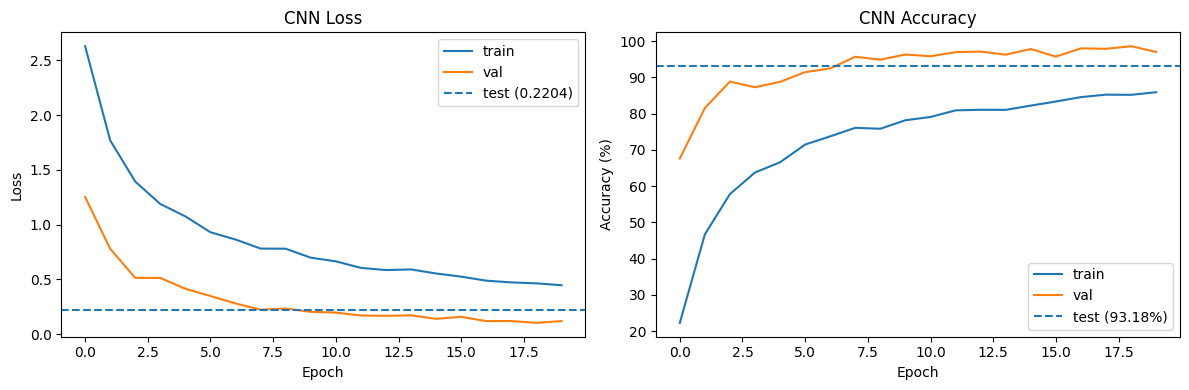

CNN classification report:
              precision    recall  f1-score   support

           A       0.94      1.00      0.97       331
           B       1.00      0.98      0.99       432
           C       1.00      0.99      0.99       310
           D       0.98      0.90      0.94       245
           E       0.94      0.96      0.95       498
           F       1.00      1.00      1.00       247
           G       0.83      0.88      0.85       348
           H       0.96      0.92      0.94       436
           I       0.99      1.00      0.99       288
           K       0.92      0.94      0.93       331
           L       1.00      0.99      0.99       209
           M       0.97      0.75      0.85       394
           N       0.85      0.70      0.77       291
           O       0.98      0.99      0.99       246
           P       0.96      0.98      0.97       347
           Q       0.98      1.00      0.99       164
           R       0.77      1.00      0.87       144


In [18]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(cnn_hist["train_loss"], label="train")
plt.plot(cnn_hist["val_loss"], label="val")
plt.axhline(test_loss, linestyle="--", label=f"test ({test_loss:.4f})")
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_hist["train_acc"], label="train")
plt.plot(cnn_hist["val_acc"], label="val")
plt.axhline(test_acc, linestyle="--", label=f"test ({test_acc:.2f}%)")
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.savefig("CNN_accuracy")
plt.show()


cnn_pred, cnn_true = predict_cnn(cnn, test_loader)

print("CNN classification report:")
print(classification_report(
    cnn_true, cnn_pred,
    target_names=[id2label[i] for i in range(num_classes)]
))


Plots confusion matrix with the test set

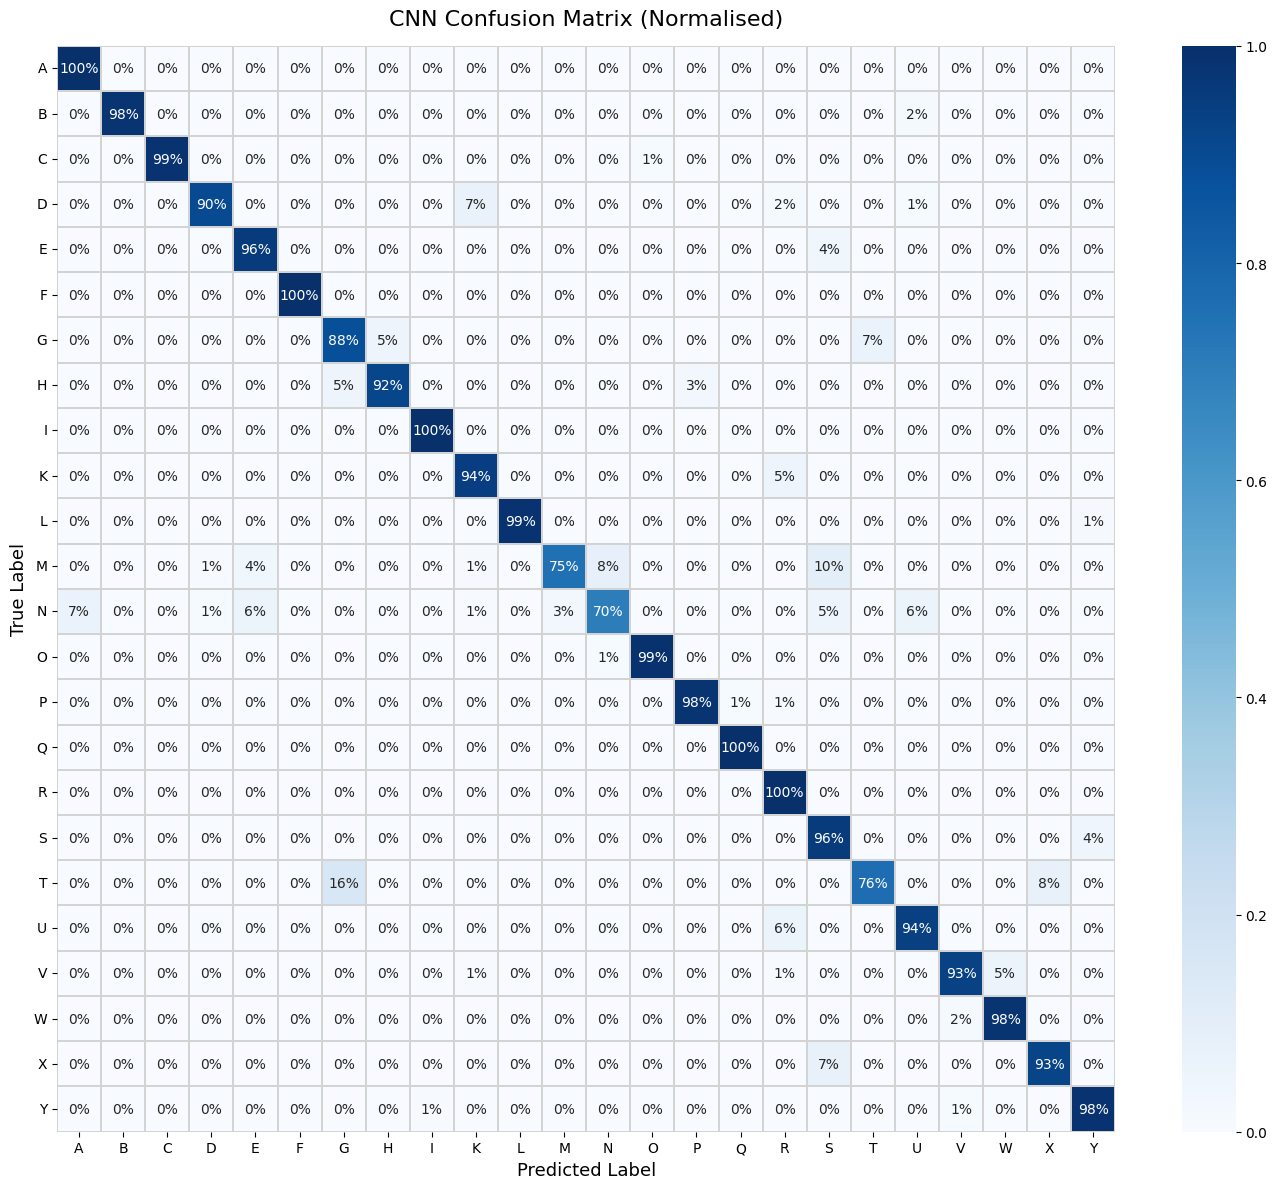

In [19]:


cm = confusion_matrix(cnn_true, cnn_pred, normalize="true")
labels = [chr(i) for i in range(ord("A"), ord("Z") + 1) if chr(i) not in ["J", "Z"]]

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0%",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.3,
    linecolor="lightgrey",
    cbar=True,
    vmin=0,
    vmax=1
)

plt.title("CNN Confusion Matrix (Normalised)", fontsize=16, pad=15)
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.savefig("confusion_cnn.png", dpi=150, bbox_inches="tight")
plt.show()

### VISION TRANSFORMER

Converts CSV rows into a Hugging Face Dataset by reconstructing images and attaching labels. 

In [20]:
#ViT pipeline
def hf_dataset(df):
    labels = df["label"].values.astype(int)
    pixels = df.drop(columns=["label"]).values.reshape(-1, 28, 28).astype(np.uint8)
    images = [Image.fromarray(img, mode="L") for img in pixels]
    return Dataset.from_dict({"image": images, "label": labels})

hf_train = hf_dataset(train_df_split)
hf_val   = hf_dataset(val_df_split)
hf_test  = hf_dataset(test_df)

ds_dict = DatasetDict({"train": hf_train, "validation": hf_val, "test": hf_test})

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Applies preprocessing using the pretrained image processor, converts images to RGB, creates pixel tensors, and remaps labels to contiguous IDs.

In [21]:
def vit_transform(examples):
    images_rgb = [img.convert("RGB") for img in examples["image"]]
    inputs = image_processor(images_rgb, return_tensors="pt")

    examples["pixel_values"] = inputs["pixel_values"]
    examples["label"] = [csv_label_to_id[int(l)] for l in examples["label"]]

    del examples["image"]
    return examples

ds_dict = ds_dict.with_transform(vit_transform)



Loads a pretrained ViT checkpoint

In [22]:
vit = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

accuracy = evaluate.load("accuracy")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defines accuracy metrics

In [23]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy.compute(predictions=preds, references=p.label_ids)





Trains using Hugging Face Trainer.

In [24]:
vit_args = TrainingArguments(
    output_dir="vit-sign-mnist",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=3e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False,
    report_to="none",
    seed=42
)

vit_trainer = Trainer(
    model=vit,
    args=vit_args,
    data_collator=DefaultDataCollator(),
    train_dataset=ds_dict["train"],
    eval_dataset=ds_dict["validation"],
    compute_metrics=compute_metrics,
)


Generates predictions for the test split.

In [25]:
vit_trainer.train()

vit_test_metrics = vit_trainer.evaluate(ds_dict["test"])
print("ViT test metrics:", vit_test_metrics)

vit_pred_out = vit_trainer.predict(ds_dict["test"])
vit_pred = np.argmax(vit_pred_out.predictions, axis=1)
vit_true = vit_pred_out.label_ids




Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.292476,1.000000
2,0.980100,0.153290,1.000000
3,0.189000,0.126510,1.000000


ViT test metrics: {'eval_loss': 0.3141869306564331, 'eval_accuracy': 0.9998605688789738, 'eval_runtime': 30.3652, 'eval_samples_per_second': 236.192, 'eval_steps_per_second': 2.47, 'epoch': 3.0}


Prints a classification report, and plots a confusion matrix.

In [26]:
print("ViT classification report:")
print(classification_report(
    vit_true, vit_pred,
    target_names=[id2label[i] for i in range(num_classes)]
))


trainable_params = vit_trainer.model.num_parameters(only_trainable=True)
print(f"Trainable Parameters: {trainable_params:,}")



ViT classification report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       331
           B       1.00      1.00      1.00       432
           C       1.00      1.00      1.00       310
           D       1.00      1.00      1.00       245
           E       1.00      1.00      1.00       498
           F       1.00      1.00      1.00       247
           G       1.00      1.00      1.00       348
           H       1.00      1.00      1.00       436
           I       1.00      1.00      1.00       288
           K       1.00      1.00      1.00       331
           L       1.00      1.00      1.00       209
           M       1.00      1.00      1.00       394
           N       1.00      1.00      1.00       291
           O       1.00      1.00      1.00       246
           P       1.00      1.00      1.00       347
           Q       1.00      1.00      1.00       164
           R       1.00      1.00      1.00       144


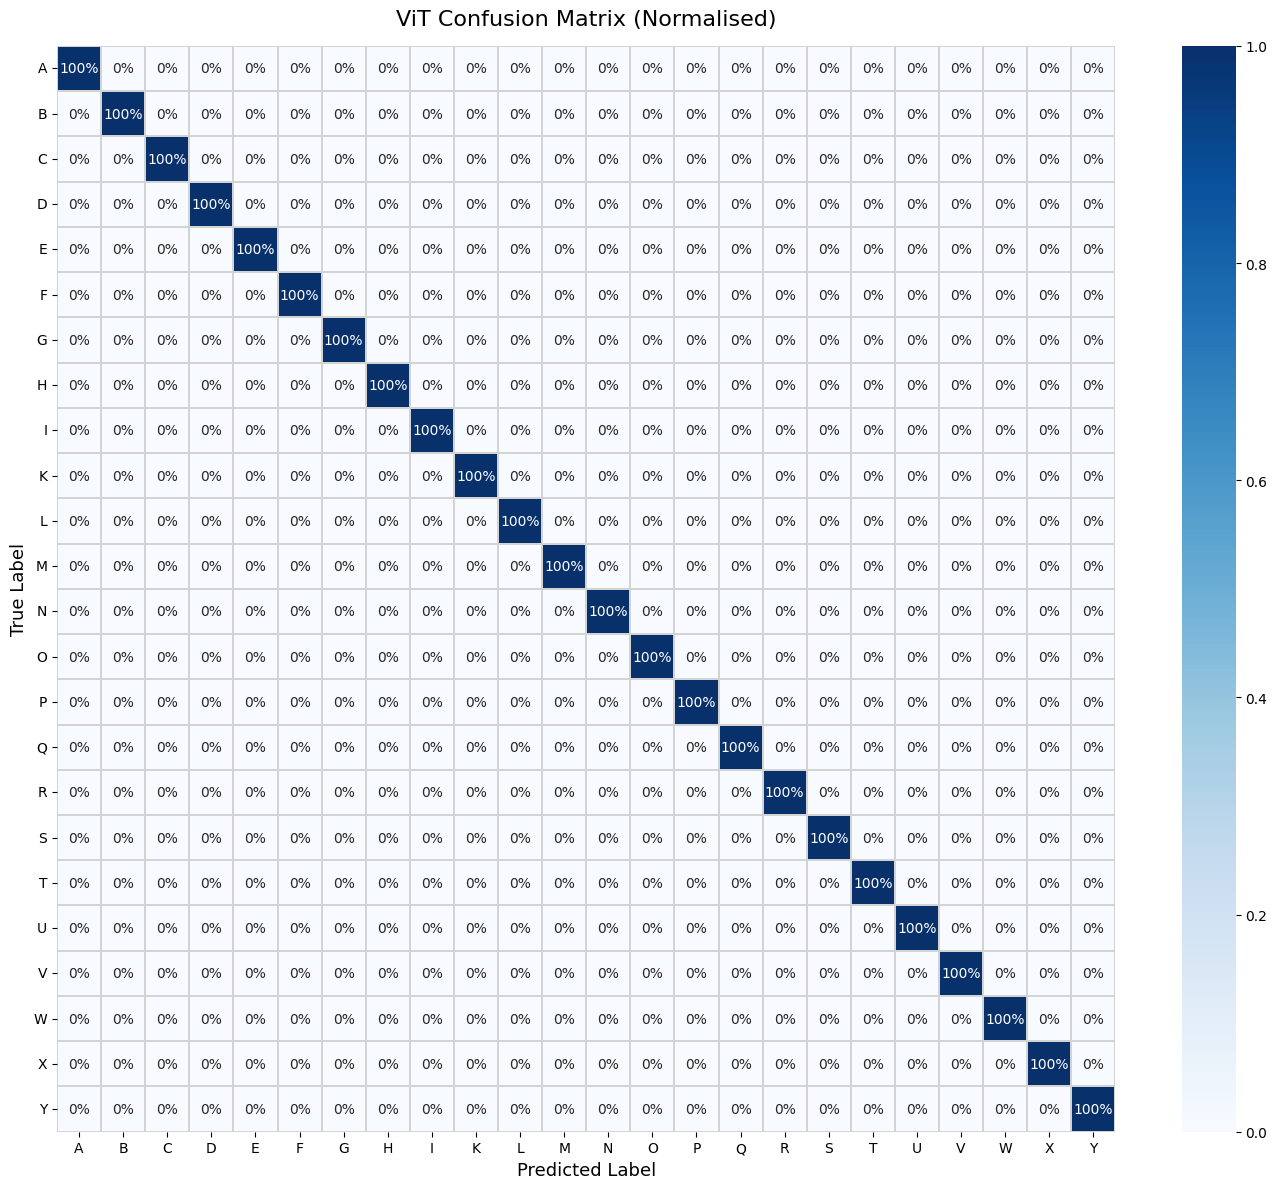

In [27]:

cm = confusion_matrix(vit_true, vit_pred, normalize="true")
labels = [chr(i) for i in range(ord("A"), ord("Z") + 1) if chr(i) not in ["J", "Z"]]

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt=".0%",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    linewidths=0.3,
    linecolor="lightgrey",
    cbar=True,
    vmin=0,
    vmax=1
)

plt.title("ViT Confusion Matrix (Normalised)", fontsize=16, pad=15)
plt.xlabel("Predicted Label", fontsize=13)
plt.ylabel("True Label", fontsize=13)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.savefig("confusion_vit.png", dpi=150, bbox_inches="tight")
plt.show()

Computes and prints final test accuracy for CNN and ViT

In [28]:

cnn_acc = (cnn_pred == cnn_true).mean()
vit_acc = (vit_pred == vit_true).mean()
print(f"\nSummary (Test Accuracy): CNN={cnn_acc:.4f} | ViT={vit_acc:.4f}")



Summary (Test Accuracy): CNN=0.9318 | ViT=0.9999
